In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats.qmc import LatinHypercube
from scipy.stats import uniform, loguniform, norm, gaussian_kde
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
import itertools  # Import the itertools module
import GPy
from scipy.spatial import ConvexHull, Voronoi
from datetime import datetime


# Guide and Ideas for Capstone Project - Function 4

# Function 4: Fast, but Inaccurate Modelling
This example is for a particular business relying heavily on online sales. It can run very accurate calculations to figure out what is the optimal placement of their product across warehouses. Unfortunately, the calculations are extremely expensive (computationally) to run, so they can only do it once every two weeks. Instead, they propose using a machine learning model which approximates the solution quickly (in a few hours). The model has four hyper-parameters you need to tune, and the output corresponds to the difference between the expensive calculation, and the model. Since you are modelling a dynamical system, expect a lot of local optima!

We begin this guide by downloading the data:

In [2]:
X = np.load('initial_data/function_4/initial_inputs.npy')
Y = np.load('initial_data/function_4/initial_outputs.npy')
print(X)
print(Y)

[[0.89698105 0.72562797 0.17540431 0.70169437]
 [0.8893564  0.49958786 0.53926886 0.50878344]
 [0.25094624 0.03369313 0.14538002 0.49493242]
 [0.34696206 0.0062504  0.76056361 0.61302356]
 [0.12487118 0.12977019 0.38440048 0.2870761 ]
 [0.80130271 0.50023109 0.70664456 0.19510284]
 [0.24770826 0.06044543 0.04218635 0.44132425]
 [0.74670224 0.7570915  0.36935306 0.20656628]
 [0.40066503 0.07257425 0.88676825 0.24384229]
 [0.6260706  0.58675126 0.43880578 0.77885769]
 [0.95713529 0.59764438 0.76611385 0.77620991]
 [0.73281243 0.14524998 0.47681272 0.13336573]
 [0.65511548 0.07239183 0.68715175 0.08151656]
 [0.21973443 0.83203134 0.48286416 0.08256923]
 [0.48859419 0.2119651  0.93917791 0.37619173]
 [0.16713049 0.87655456 0.21723954 0.95980098]
 [0.21691119 0.16608583 0.24137226 0.77006248]
 [0.38748784 0.80453226 0.75179548 0.72382744]
 [0.98562189 0.66693268 0.15678328 0.8565348 ]
 [0.03782483 0.66485335 0.16198218 0.25392378]
 [0.68348638 0.9027701  0.33541983 0.99948256]
 [0.17034731 

In [3]:
def format_query(point, NoOfDigits):
    return '-'.join(f"{x:.{NoOfDigits}f}" for x in point)

In [4]:
def print_timestamp():
    # Print out the timestamp
    print("Current Timestamp: ", datetime.now())

In [5]:
# Print X with 16 digits of precision
for row in X:
    print(format_query(row,16))

# Print a separator line
print("-" * 50)

# Print Y with 16 digits of precision
print(format_query(Y,16))

0.8969810543559719-0.7256279703482243-0.1754043089024115-0.7016943693717497
0.8893563957199797-0.4995878553769650-0.5392688577643431-0.5087834390633533
0.2509462427523342-0.0336931305473536-0.1453800247355215-0.4949324205649785
0.3469620609143241-0.0062504002449179-0.7605636064368956-0.6130235572343078
0.1248711812207095-0.1297701930651067-0.3844004830013034-0.2870761010606128
0.8013027073487429-0.5002310937156627-0.7066445599562093-0.1951028410119162
0.2477082618994807-0.0604454273219898-0.0421863451371978-0.4413242505440316
0.7467022420948025-0.7570915044306501-0.3693530595537917-0.2065662810376639
0.4006650271944230-0.0725742510712734-0.8867682538447798-0.2438422897892272
0.6260705961944015-0.5867512592598441-0.4388057821707446-0.7788576937904925
0.9571352930644363-0.5976443830130996-0.7661138515714809-0.7762099053238541
0.7328124260168783-0.1452499789735880-0.4768127176311528-0.1333657340458458
0.6551154792459779-0.0723918269048233-0.6871517458198465-0.0815165641903302
0.2197344291

In [6]:
# load w1 data
pd_new = pd.read_csv("data/capstone_results.csv")
print(pd_new.head(10))

   Week  Student  Fn        X1        X2        X3        X4        X5  \
0     1      427   1  0.605439  0.664755       NaN       NaN       NaN   
1     1      427   2  0.929767  0.997474       NaN       NaN       NaN   
2     1      427   3  0.990000  0.990000  0.000000       NaN       NaN   
3     1      427   4  0.459180  0.459289  0.399209  0.408363       NaN   
4     1      427   5  0.261839  0.845899  0.945459  0.906905       NaN   
5     1      427   6  0.464312  0.339986  0.491438  0.749695  0.159201   
6     1      427   7  0.000000  0.268289  0.446722  0.095962  0.273324   
7     1      427   8  0.088905  0.288209  0.044306  0.256810  0.634647   
8     1      428   1  0.628540  0.628540       NaN       NaN       NaN   
9     1      428   2  0.983984  0.999998       NaN       NaN       NaN   

         X6        X7       X8            Y  
0       NaN       NaN      NaN     0.007671  
1       NaN       NaN      NaN    -0.011315  
2       NaN       NaN      NaN    -0.146375  
3

In [7]:
pw_fn = pd_new[pd_new['Fn']==4]
# Extract X1 and X2 into a 2D array and Y into a 1D array
# Here we're ensuring to drop any NaN values as they can't be used in most models.
X_new_points = pw_fn[['X1','X2','X3','X4']].dropna().values
Y_new_points = pw_fn['Y'].dropna().values
print(X_new_points)
print(Y_new_points)

[[0.45918  0.459289 0.399209 0.408363]
 [0.421053 0.368421 0.368421 0.421053]
 [0.825769 0.819615 0.861174 0.78678 ]
 [0.421053 0.421053 0.315789 0.421053]
 [0.425358 0.392912 0.36824  0.418466]
 [0.259511 0.301324 0.374931 0.469123]
 [0.4375   0.4375   0.375    0.4375  ]
 [0.950969 0.899787 0.809056 0.524586]
 [0.5      0.5      0.5      0.5     ]
 [0.       0.473684 0.736842 0.999   ]
 [0.007258 0.996498 0.997746 0.100835]
 [0.36072  0.317768 0.368493 0.367156]
 [0.15     0.15     0.15     0.15    ]
 [0.999999 0.75     0.4375   0.      ]
 [0.908192 0.676537 0.48325  0.965994]
 [0.603717 0.521241 0.548135 0.513091]
 [0.117356 0.489231 0.805511 0.467611]
 [0.578404 0.438635 0.274975 0.333669]
 [0.5      0.7      0.7      0.7     ]
 [0.375    0.375    0.375    0.4375  ]
 [0.996262 0.251493 0.366023 0.845836]
 [0.825769 0.819615 0.861174 0.78678 ]
 [0.429617 0.395992 0.352362 0.414986]
 [0.577765 0.428771 0.425825 0.249007]]
[ -1.08102009   0.69206692 -30.72781284  -0.09983279   0.589532

In [8]:
#append w1 data to the end

X_updated = np.vstack((X, X_new_points))
Y_updated = np.append(Y, Y_new_points)
print(X_updated)
print(Y_updated)

[[0.89698105 0.72562797 0.17540431 0.70169437]
 [0.8893564  0.49958786 0.53926886 0.50878344]
 [0.25094624 0.03369313 0.14538002 0.49493242]
 [0.34696206 0.0062504  0.76056361 0.61302356]
 [0.12487118 0.12977019 0.38440048 0.2870761 ]
 [0.80130271 0.50023109 0.70664456 0.19510284]
 [0.24770826 0.06044543 0.04218635 0.44132425]
 [0.74670224 0.7570915  0.36935306 0.20656628]
 [0.40066503 0.07257425 0.88676825 0.24384229]
 [0.6260706  0.58675126 0.43880578 0.77885769]
 [0.95713529 0.59764438 0.76611385 0.77620991]
 [0.73281243 0.14524998 0.47681272 0.13336573]
 [0.65511548 0.07239183 0.68715175 0.08151656]
 [0.21973443 0.83203134 0.48286416 0.08256923]
 [0.48859419 0.2119651  0.93917791 0.37619173]
 [0.16713049 0.87655456 0.21723954 0.95980098]
 [0.21691119 0.16608583 0.24137226 0.77006248]
 [0.38748784 0.80453226 0.75179548 0.72382744]
 [0.98562189 0.66693268 0.15678328 0.8565348 ]
 [0.03782483 0.66485335 0.16198218 0.25392378]
 [0.68348638 0.9027701  0.33541983 0.99948256]
 [0.17034731 

In [9]:
def get_weekly_data(fn_no, week_no, pd_new):
    # Define the number of dimensions for each function
    fn_dim = {1: 2, 2: 2, 3: 3, 4: 4, 5: 4, 6: 5, 7: 6, 8: 8}
    
    # Get the number of dimensions for the given function number
    num_dim = fn_dim.get(fn_no, 2)  # Default to 2 if not specified

    # Filter the DataFrame for the specific week and function
    pd_fn = pd_new[(pd_new['Fn'] == fn_no) & (pd_new['Week'] == week_no)]
    
    # Dynamically create a list of 'X' column names based on the number of dimensions
    x_columns = [f'X{i}' for i in range(1, num_dim + 1)]

    # Extract X and Y values, dropping any rows with missing data
    X_new_week = pd_fn[x_columns].dropna().values
    Y_new_week = pd_fn['Y'].dropna().values
    
    return X_new_week, Y_new_week


print(get_weekly_data(4,2,pd_new))
print("\n")
print(get_weekly_data(4,2,pd_new))

(array([[0.950969, 0.899787, 0.809056, 0.524586],
       [0.5     , 0.5     , 0.5     , 0.5     ],
       [0.      , 0.473684, 0.736842, 0.999   ],
       [0.007258, 0.996498, 0.997746, 0.100835],
       [0.36072 , 0.317768, 0.368493, 0.367156],
       [0.15    , 0.15    , 0.15    , 0.15    ],
       [0.999999, 0.75    , 0.4375  , 0.      ]]), array([-30.82356313,  -3.98575097, -27.55163667, -37.84611286,
        -0.19756966, -11.71925969, -27.32432156]))


(array([[0.950969, 0.899787, 0.809056, 0.524586],
       [0.5     , 0.5     , 0.5     , 0.5     ],
       [0.      , 0.473684, 0.736842, 0.999   ],
       [0.007258, 0.996498, 0.997746, 0.100835],
       [0.36072 , 0.317768, 0.368493, 0.367156],
       [0.15    , 0.15    , 0.15    , 0.15    ],
       [0.999999, 0.75    , 0.4375  , 0.      ]]), array([-30.82356313,  -3.98575097, -27.55163667, -37.84611286,
        -0.19756966, -11.71925969, -27.32432156]))


## Random Search

The simplest solution would be a simple random search, that is, we can randomly choose our next query point:

In [10]:
# Approach 1
next_query = np.random.uniform(size = 4)
print(next_query)

[0.91167161 0.06191786 0.77031514 0.28400187]


While this solution is easy to implement, we know it will be very slow. However, it could serve as a placeholder for gathering more information while you research which method you want to use for each function.

## Visualizing our data and thinking of the problem

Analysis of Initial Dataset: The initial dataset provided gives a starting point. Analyzing this data using statistical techniques or visualization might provide insights into the behavior of the functions and where to search next.

what we know about the problem:

1.From the hints, expect a lot of local optima.

In [11]:
# Convert to DataFrame for easier handling
df = pd.DataFrame(X_updated, columns=['x1', 'x2', 'x3', 'x4'])
df['output'] = Y_updated

In [12]:
# Statistical Summary
print("Statistical Summary:")
print(df.describe())


Statistical Summary:
              x1         x2         x3         x4     output
count  54.000000  54.000000  54.000000  54.000000  54.000000
mean    0.526234   0.494412   0.485656   0.480394 -15.133712
std     0.291688   0.269861   0.244583   0.273162  10.568746
min     0.000000   0.006250   0.042186   0.000000 -37.846113
25%     0.293123   0.330431   0.339655   0.250237 -24.755067
50%     0.494297   0.485667   0.431663   0.454468 -14.356745
75%     0.787653   0.719221   0.708686   0.718294  -6.523339
max     0.999999   0.996498   0.997746   0.999483   0.692067


[0.4083697  0.60316072 0.67844876 0.56547424 0.72075224 0.58017868
 0.65297396 0.56618432 0.5396435  0.65141496 0.27322817 0.63102264
 0.54924747 0.55370945 0.51969537 0.29280812 0.6509853  0.4775668
 0.23205142 0.62647915 0.21845924 0.68193078 0.28512832 0.77531782
 0.80813427 0.13546184 0.46334869 0.87758609 0.64152824 0.38161336
 0.95399142 1.         0.18470774 0.97945155 0.99733941 0.90384754
 0.98621408 0.18222318 0.87861861 0.26712409 0.         0.97691545
 0.67794725 0.27302253 0.23543627 0.8143186  0.61545137 0.87921599
 0.60356667 0.98869503 0.32571595 0.18470774 0.99679376 0.87758614]


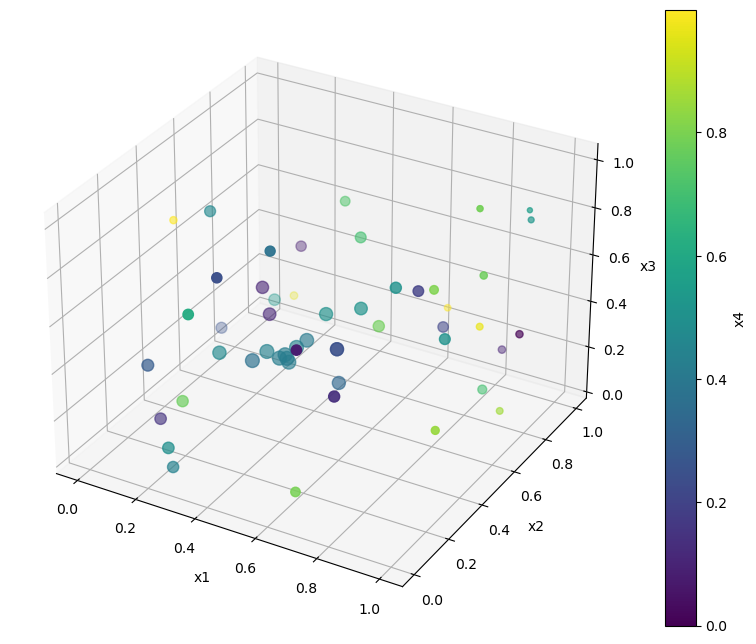

In [13]:
# Normalize Y for better visualization
Y_norm = (Y_updated - Y_updated.min()) / (Y_updated.max() - Y_updated.min())
print(Y_norm)

# Size scaling factor - you can adjust this
size_scale = 100 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use color for the fourth dimension and size for the fifth dimension
sc = ax.scatter(X_updated[:, 0], X_updated[:, 1], X_updated[:, 2], c=X_updated[:, 3], cmap='viridis', s=Y_norm * size_scale)

# Create colorbar
cbar = plt.colorbar(sc)
cbar.set_label('x4')

# Set labels for axes
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

# Show plot
plt.show()

## Maximum Empty Circle or MEC in a Voronoi diagram (Convex)

In [14]:

# Replace with the 4D points
# Example: points = np.random.rand(10, 4)
points = X_updated  # 4D dataset

# Creating the Voronoi diagram for 4D points
vor = Voronoi(points)

# Compute Convex Hull in 4D
hull = ConvexHull(points)

# Function to check if a point is inside the convex hull
def in_hull(p, hull):
    return all((np.dot(eq[:-1], p) + eq[-1] <= 0) for eq in hull.equations)

# Find the largest empty sphere in 4D
max_radius = 0
center_of_max_sphere = None

for vertex in vor.vertices:
    if in_hull(vertex, hull):
        min_distance_to_point = min(np.linalg.norm(vertex - point) for point in points)
        if min_distance_to_point > max_radius:
            max_radius = min_distance_to_point
            center_of_max_sphere = vertex

# Visualization is not feasible directly in 4D
# You can print the results or analyze them programmatically
if center_of_max_sphere is not None:
    print(f"Center of the largest empty sphere: {format_query(center_of_max_sphere,6)}")
    print("Radius of the largest empty sphere:", max_radius)
else:
    print("No empty sphere found within the convex hull.")
    
print_timestamp()

Center of the largest empty sphere: 0.527994-0.895273-0.828550-0.259220
Radius of the largest empty sphere: 0.49972726773363474
Current Timestamp:  2024-02-11 20:16:29.779179


## Maximum Empty Circle or MEC in a Voronoi diagram

In [15]:
from scipy.spatial import Voronoi

def largest_empty_circle(points):
    # Compute Voronoi diagram
    vor = Voronoi(points)
    
    # Iterate over Voronoi regions
    max_radius = 0
    best_point = None
    for point, region in zip(vor.points, vor.regions):
        if not region or -1 in region:
            continue

        # Compute the distances from the point to all edges of its Voronoi region
        region_points = np.asarray([vor.vertices[i] for i in region])
        distances = np.sqrt(((region_points - point) ** 2).sum(axis=1))

        # Find the maximum distance
        min_distance = np.min(distances)
        if min_distance > max_radius:
            max_radius = min_distance
            best_point = point

    return best_point, max_radius

# dataset points
points = X_updated
center, radius = largest_empty_circle(points)


if center is not None:
    print("Center of the largest empty circle:", format_query(center,6))
    print("Radius of the largest empty circle:", radius)
else:
    print("No empty circle found.")
    
print_timestamp()

Center of the largest empty circle: 0.007258-0.996498-0.997746-0.100835
Radius of the largest empty circle: 0.804322015598218
Current Timestamp:  2024-02-11 20:16:32.289399


## The best point is [0.007258, 0.996498, 0.997746, 0.100835]


In [16]:
# updated 4D dataset
points = X_updated

# Fit KDE to data
data_kde = gaussian_kde(points.T)

# Best point coordinates for 4D
best_points = [0.007258, 0.996498, 0.997746, 0.100835]  

# Define the threshold for each dimension
threshold = 0.2  # Example threshold value

# Calculate min and max values for each dimension based on the threshold
min_values = [x - threshold for x in best_points]
max_values = [x + threshold for x in best_points]

# Increase the number of samples significantly
num_samples = 100000  # Larger number of samples

# Sample new points from the KDE
kde_samples = data_kde.resample(size=num_samples)

# Filter the samples to only keep those within the defined region
conditions = [(kde_samples[i] >= min_values[i]) & (kde_samples[i] <= max_values[i]) for i in range(len(best_points))]
conditions += [(kde_samples[i] >= 0) & (kde_samples[i] <= 1) for i in range(len(best_points))]  # Ensure all dimensions are within [0, 1]
kde_samples_filtered = kde_samples[:, np.all(conditions, axis=0)].T

# Check if we have any points after filtering
if kde_samples_filtered.size == 0:
    raise ValueError("No points sampled within the specified region.")

# The target point in 4D
target_point = np.array(best_points)

# Compute the Euclidean distances from each point in the dataset to the target point
distances = np.linalg.norm(kde_samples_filtered - target_point, axis=1)

# Get the indices of the 10 closest points
closest_indices = np.argsort(distances)[:10]

# Retrieve the closest points using these indices
closest_points = kde_samples_filtered[closest_indices]

print("The 10 closest points to", best_points, "are:")
print(closest_points)


The 10 closest points to [0.007258, 0.996498, 0.997746, 0.100835] are:
[[0.03371157 0.97153941 0.932285   0.1012447 ]
 [0.00768894 0.9657123  0.92298172 0.07691452]
 [0.0817953  0.96449515 0.98305482 0.17264471]
 [0.0582925  0.88951524 0.9733626  0.06819656]
 [0.01542778 0.94032691 0.90936337 0.02828693]
 [0.06356182 0.8818308  0.98194541 0.10186855]
 [0.0606624  0.95525376 0.92646481 0.18521006]
 [0.01279693 0.96450825 0.88527083 0.15760923]
 [0.05093527 0.98751291 0.92698082 0.20263438]
 [0.04991735 0.94907    0.88754597 0.05610352]]


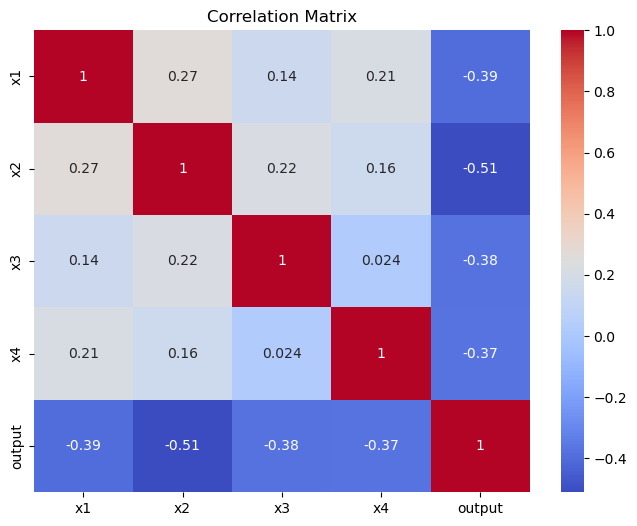

 C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:The figure layout has changed to tight


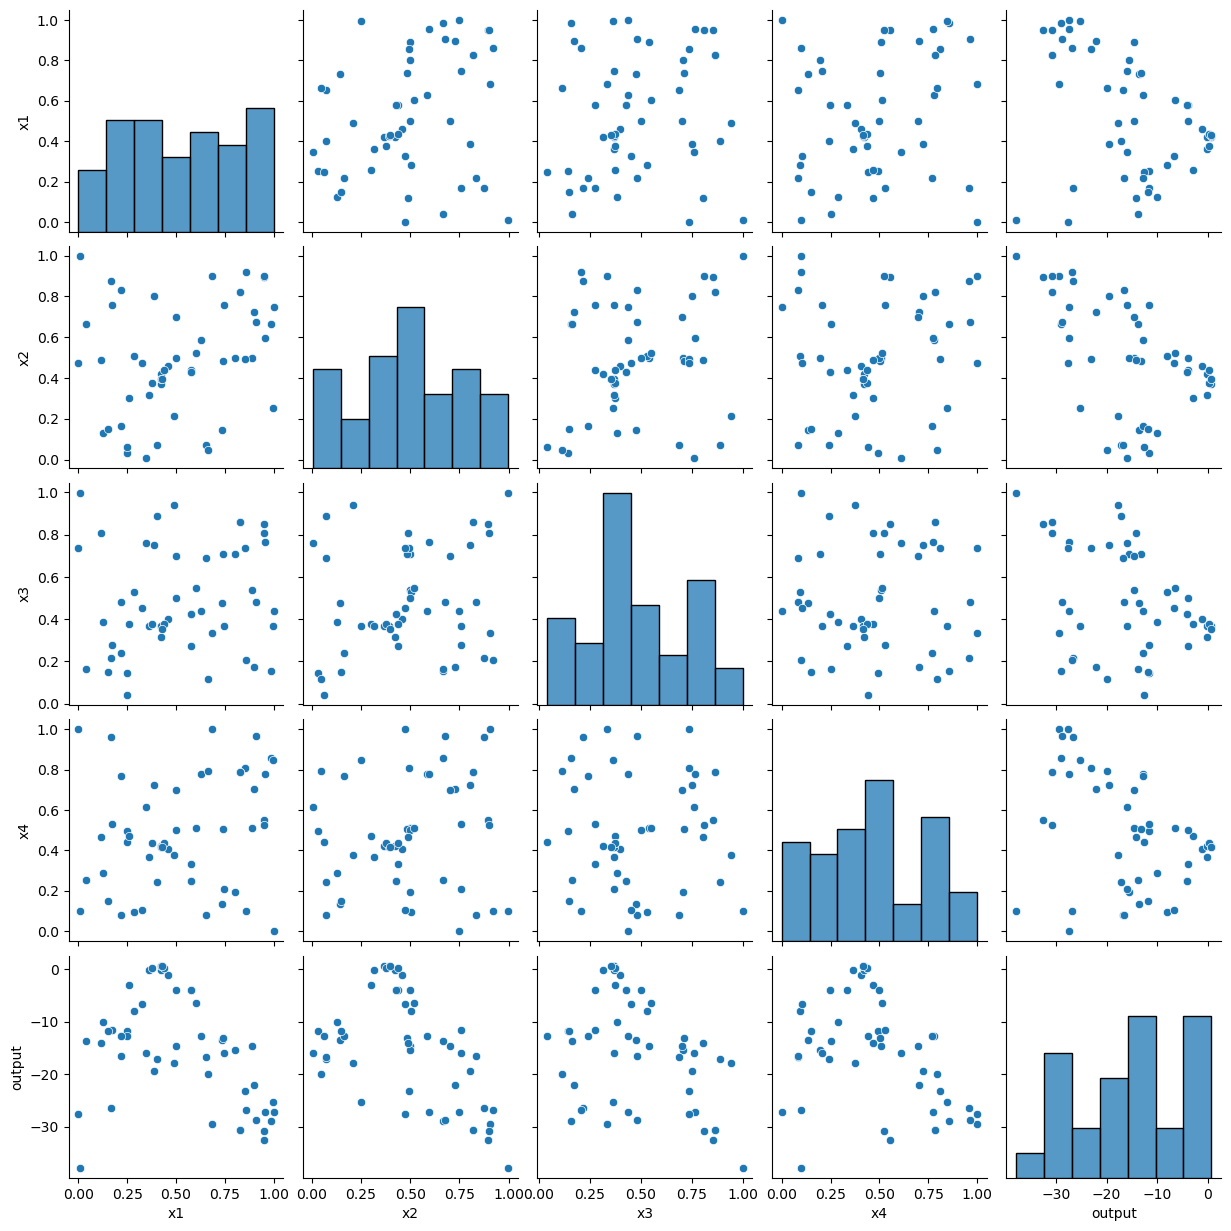

In [17]:
# Calculate correlations
correlations = df.corr()

# Plotting the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot to visualize relationships
sns.pairplot(df)
plt.show()

In [18]:
def compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi):
    """
    Compute kappa and xi values for each week in an optimization loop.

    Parameters:
    N_WEEKS: Number of weeks for the optimization loop.
    kappa_initial: Initial value of kappa.
    kappa_decay: Decay rate of kappa per week.
    min_kappa: Minimum value of kappa.
    xi_initial: Initial value of xi.
    xi_decay: Decay rate of xi per week.
    min_xi: Minimum value of xi.

    Returns:
    kappa_array: Array of kappa values for each week.
    xi_array: Array of xi values for each week.
    """

    kappa_array = np.zeros(N_WEEKS)
    xi_array = np.zeros(N_WEEKS)

    for week in range(N_WEEKS):
        kappa = max(kappa_initial * (kappa_decay ** week), min_kappa)
        xi = max(xi_initial * (xi_decay ** week), min_xi)
        kappa_array[week] = kappa
        xi_array[week] = xi

    return kappa_array, xi_array

# Example usage:
N_WEEKS = 10
kappa_initial = 1.96
kappa_decay = 0.9
min_kappa = 0.1
xi_initial = 0.1
xi_decay = 0.9
min_xi = 0.01

kappa_array, xi_array = compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi)
print("Kappa Array:", kappa_array)
print("Xi Array:", xi_array)

Kappa Array: [1.96       1.764      1.5876     1.42884    1.285956   1.1573604
 1.04162436 0.93746192 0.84371573 0.75934416]
Xi Array: [0.1        0.09       0.081      0.0729     0.06561    0.059049
 0.0531441  0.04782969 0.04304672 0.03874205]


In [19]:
#Evaluate Model Performance

def evaluate_model_performance(model, X_test, Y_test, model_type='sklearn'):
    """
    Evaluate the performance of a Gaussian Process model.

    Parameters:
    model: The trained Gaussian Process model.
    X_test: Test data features (numpy array).
    Y_test: True values for test data (numpy array).

    Returns:
    mse: Mean Squared Error of the model on the test data.
    r2: R-squared value indicating the proportion of variance explained by the model.
    """

    if model_type == 'gpy':
        y_pred, var_pred = model.predict(X_test)
        std_pred = np.sqrt(var_pred)
    elif model_type == 'sklearn':
        y_pred, std_pred = model.predict(X_test, return_std=True)

    # Ensure y_pred is 1D
    y_pred = y_pred.flatten()

    # Calculate residuals
    residuals = Y_test.flatten() - y_pred

    # Check if dimensions match
    if y_pred.shape != residuals.shape:
        raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} and residuals shape {residuals.shape} must be the same.")        
        
    # Calculate MSE and R-squared
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")

    # Analyze residuals
    residuals = Y_test - y_pred

    # Plot residuals to look for patterns
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    return mse, r2

# Usage example:
# mse, r2 = evaluate_model_performance(best_gp, X_w1_new_points, Y_w1_new_points)
# print(f"MSE: {mse}")
# print(f"R-squared: {r2}")

In [20]:
# define multiple acquisition functions

#an acquisition function used in Bayesian optimization. 
# The EI is calculated for a set of points X, given a Gaussian process gp. It's used to determine the next point to sample.
def expected_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei


# Probability of Improvement acquisition function
def probability_of_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0

    return pi


# Define the UCB acquisition function
# After optimizing the hyperparameters, the Upper Confidence Bound (UCB) is used as the acquisition function in the weekly optimization loop. 
# The UCB balances exploration (trying new, uncertain points) and exploitation (focusing on points known to yield good results).
def upper_confidence_bound(X_grid, gp, kappa=1.96, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)

    return mu + kappa * sigma

In [21]:
# define grid based on dimensions

def generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points):
    """
    Generate a 2D grid of points for optimization.

    Parameters:
    domain_start_x1: Starting value of the first dimension.
    domain_end_x1: Ending value of the first dimension.
    domain_start_x2: Starting value of the second dimension.
    domain_end_x2: Ending value of the second dimension.
    num_points: Number of points to generate in each dimension.

    Returns:
    X_grid: A 2D numpy array of grid points.
    """

    # Generate arrays of evenly spaced values in each dimension
    x1 = np.linspace(domain_start_x1, domain_end_x1, num_points)
    x2 = np.linspace(domain_start_x2, domain_end_x2, num_points)

    # Use numpy's meshgrid function to create a grid efficiently
    X_grid = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)

    return X_grid
# Example usage:
# domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2 = 0.6, 0.65, 0.6, 0.65
# num_points = 100
# X_grid = generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points)

def generate_nd_grid(max_points, dimensions):
    # define range for input
	r_min, r_max = 0, 1.0

	# generate a random sample from the domain (dimensions)
	nd_grid = r_min + np.random.rand(max_points, dimensions) * (r_max - r_min)
	
	return np.array(nd_grid)

In [22]:
# propose the next points for all three acquisition functions

def propose_next_point(xi, kappa, X_grid, best_gp, model_type = 'sklearn'):
    """
    Update exploration-exploitation parameters and calculating next query points.
   
    Returns:
    Next query points for EI, PI, and UCB.
    """


    # EI next point calculation
    ei_values = expected_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_ei = np.argmax(ei_values)
    next_point_ei = X_grid[next_point_index_ei]
    print('Next query EI: ', format_query(next_point_ei, 6))

    # PI next point calculation
    pi_values = probability_of_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_pi = np.argmax(pi_values)
    next_point_pi = X_grid[next_point_index_pi]
    print('Next query PI: ', format_query(next_point_pi, 6))

    # UCB next point calculation
    ucb_value = upper_confidence_bound(X_grid, best_gp, kappa,model_type)
    next_point_index_ucb = np.argmax(ucb_value)
    next_point_ucb = X_grid[next_point_index_ucb]
    print('Next query UCB: ', format_query(next_point_ucb, 6))

    return next_point_ei, next_point_pi, next_point_ucb

# Approach 2 sklearn: Surrogate - using sklearn GP model train accumulatively& RandomisedSearchCV for hyperparameter optimisation¶

In [23]:
#Approach 2 - modified
#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.
param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-3, 1e3),
    'kernel__k2__length_scale': loguniform(1e-4, 1e2)
    #'k2__noise_level': loguniform(1e-3, 1e1)
}

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))  

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_updated,Y_updated)

best_gp = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

print_timestamp()

 C:\ProgramData\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Best Parameters: {'kernel__k1__constant_value': 0.1767016940294795, 'kernel__k2__length_scale': 50.61576888752309}
Log-marginal-likelihood: -138.60318893908885
Current Timestamp:  2024-02-11 20:18:37.887580


# Approach 2 sklearn: train accumulatively & BayesSearchCV for hyperparameter optimisation

In [25]:
from skopt import BayesSearchCV
from skopt.space import Real

# Define the kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))  

# Create a Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

# Define the search space for the hyperparameters
search_spaces = {
    'kernel__k1__constant_value': Real(1e-4, 1e4, prior='log-uniform'),
    'kernel__k2__length_scale': Real(1e-5, 1e3, prior='log-uniform')
    # You can also add 'k2__noise_level' if needed
}

# Instantiate BayesSearchCV
bayes_search = BayesSearchCV(gp, search_spaces, n_iter=10, cv=10, random_state=42, n_jobs=-1)

# Fit the model
bayes_search.fit(X_updated, Y_updated)

# Retrieve the best model and parameters
best_gp = bayes_search.best_estimator_
best_params = bayes_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

print_timestamp()


 C:\ProgramData\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Best Parameters: OrderedDict([('kernel__k1__constant_value', 315.62246465541887), ('kernel__k2__length_scale', 0.00023712235042499275)])
Log-marginal-likelihood: -138.6031722584928
Current Timestamp:  2024-02-11 20:26:23.785463


## Approach 2 sklearn: train accumulatively - different kernel with better log value¶

In [26]:
#from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic, WhiteKernel
#from sklearn.model_selection import RandomizedSearchCV
#from scipy.stats import loguniform
from sklearn.model_selection import GridSearchCV

# Define parameter grid with fixed values
param_grid = {
    'kernel': [
        C(constant_value) * RationalQuadratic(alpha=alpha, length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
        for constant_value in np.logspace(-3, 3, num=5)  # Example range for constant_value
        for alpha in np.logspace(-2, 1, num=5)          # Example range for alpha
        for length_scale in np.logspace(-2, 2, num=5)   # Example range for length_scale
        for noise_level in [1, 10, 100]                 # Example fixed values for noise_level
    ]
}

# Instantiate Gaussian Process Regressor
gp = GaussianProcessRegressor(n_restarts_optimizer=20)

grid_search = GridSearchCV(gp, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_updated, Y_updated)

# Retrieve the best model and parameters
best_gp = grid_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

print_timestamp()

Best Parameters: {'kernel__k1__constant_value': 0.1767016940294795, 'kernel__k2__length_scale': 50.61576888752309}
Log-marginal-likelihood: -112.76094375245822
Current Timestamp:  2024-02-11 20:40:28.765243


## Approach 2: Surrogate - using sklearn GP model train sequentially

In [ ]:
#Approach 2 - alternative
#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.
# Define your initial kernel and model
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

# Define hyperparameter search space
param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-4, 1e3),
    'kernel__k2__length_scale': loguniform(1e-4, 1e2)
}

# Function to update model with new data and optimize hyperparameters
def update_and_optimize_model(gp, X_train, Y_train):
    # Update the model with new data
    gp.fit(X_train, Y_train)

    # Hyperparameter optimization
    random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train, Y_train)

    # Best model and parameters
    best_gp = random_search.best_estimator_
    best_params = random_search.best_params_
    print("Best Parameters:", best_params)
    print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}") # Higher values typically indicate a better fit. can sometimes indicate overfitting
    
    return best_gp

# Initial training data
X_train = X # the initial X data
Y_train = Y # the initial Y data

# Initial model fitting and hyperparameter optimization
best_gp = update_and_optimize_model(gp, X_train, Y_train)

number_of_weeks =2 # this is the 3rd week, we have additional 2 weeks data

# Example usage for weekly updates
for week in range(number_of_weeks):
    print(f"week = {week}")
    # Assume X_new_week and Y_new_week are the new data you receive every week
    X_new_week, Y_new_week = get_weekly_data(4,week+1, pd_new)
    
    # Combine old training data with new data
    X_train = np.vstack((X_train, X_new_week))
    Y_train = np.hstack((Y_train, Y_new_week))

    # Update the model with new data and optimize hyperparameters
    best_gp = update_and_optimize_model(best_gp, X_train, Y_train)


## Appoach 2: using sklearn GP model via random generated grid

Next query EI:  0.439953-0.337146-0.735072-0.687429
Next query PI:  0.400684-0.381371-0.342190-0.416621
Next query UCB:  0.400684-0.381371-0.342190-0.416621
MSE: 0.18733885076591358
R-squared: 0.998914866855315


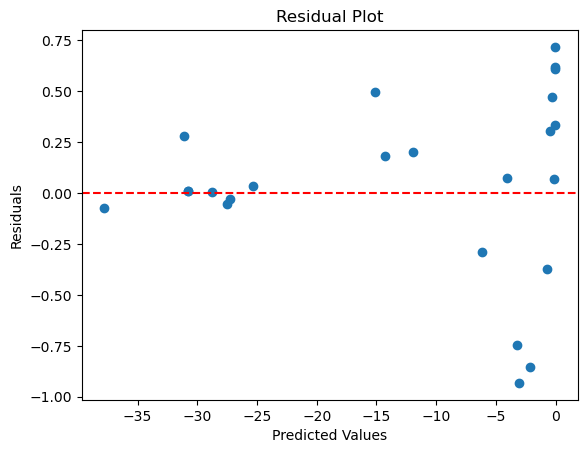

Current Timestamp:  2024-02-11 20:41:47.744513


In [27]:
#Approach 2: using sklearn GP model

# generate grid
max_points = 7000000 #9,000,000 (too big for memory)
dimensions = 4  # Change this to the desired number of dimensions
X_grid = []
X_grid = generate_nd_grid(max_points, dimensions)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 4  # For week 5, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid,best_gp,'sklearn')

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")
print_timestamp()

## Appoach 2: using sklearn GP model via Voronoi diagram generated grid

Next query EI:  0.166255-0.950798-0.973495-0.231783
Next query PI:  0.194382-0.827930-0.837341-0.239985
Next query UCB:  0.194382-0.827930-0.837341-0.239985
MSE: 0.18733885076591358
R-squared: 0.998914866855315


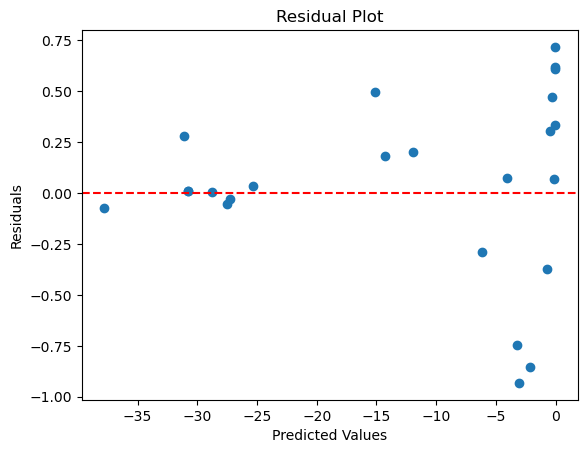

Current Timestamp:  2024-02-11 20:52:10.580202


In [28]:
# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 4  # For week 5, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,kde_samples_filtered,best_gp,'sklearn')

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")
print_timestamp()

 <span style="color:red; font-size:30px;"> # Approach 2 alternative : Surrogate - using sklearn GP model with noise, just for comparison </span>

In [29]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# Create a kernel with an RBF and a WhiteKernel component
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(noise_level=0.1)

# Create the GP model
gp_noise = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the model
gp_noise.fit(X_updated, Y_updated)

# The noise level is part of the kernel parameters after fitting
print("Kernel parameters including noise level:", gp_noise.kernel_)
print_timestamp()


Kernel parameters including noise level: 31.6**2 * RBF(length_scale=1.01) + WhiteKernel(noise_level=0.371)
Current Timestamp:  2024-02-11 20:53:33.805771


 C:\ProgramData\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.


Next query EI:  0.837567-0.242422-0.362053-0.223873
Next query PI:  0.396333-0.393171-0.358741-0.415035
Next query UCB:  0.396333-0.393171-0.358741-0.415035
MSE: 0.25219749477039216
R-squared: 0.9985391825589673


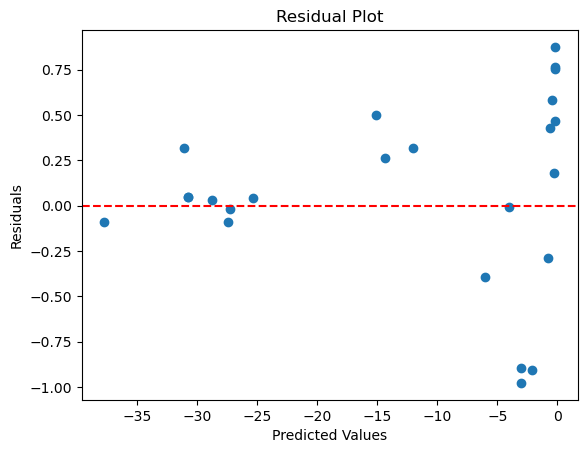

Current Timestamp:  2024-02-11 20:54:21.664299


In [30]:
#Approach 2: using sklearn GP model

# generate grid
max_points = 7000000 #9,000,000 (too big for memory)
dimensions = 4  # Change this to the desired number of dimensions
X_grid = []
X_grid = generate_nd_grid(max_points, dimensions)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 3  # For week 4, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid,gp_noise,'sklearn')

mse, r2 = evaluate_model_performance(gp_noise, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")
print_timestamp()

## Appoach 2: using sklearn GP model with noise via Voronoi diagram generated grid

Next query EI:  0.166255-0.950798-0.973495-0.231783
Next query PI:  0.170230-0.999840-0.988517-0.046149
Next query UCB:  0.194382-0.827930-0.837341-0.239985
MSE: 0.18733885076591358
R-squared: 0.998914866855315


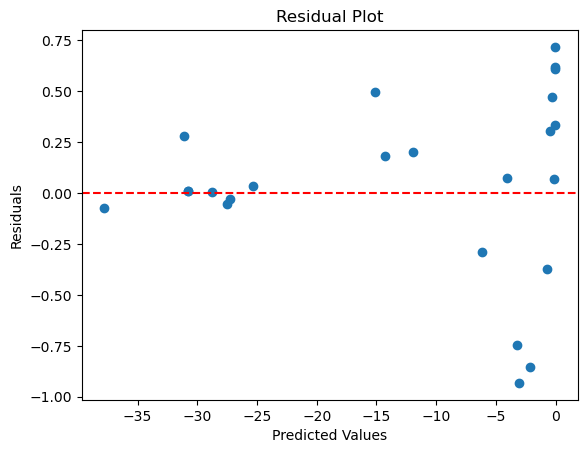

Current Timestamp:  2024-02-11 21:02:07.429182


In [31]:
# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 4  # For week 5, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,kde_samples_filtered,gp_noise,'sklearn')

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

## Aproach 3:  Surrogate model -  a Sparse Gaussian Process model

In [32]:
# Approach 3: gpy GP model

# Assuming X_w1 and Y_w1 are your data points
# Ensure X_w1 and Y_w1 are correctly shaped
# X_w1 = ... (your data, should be 2D, e.g., [n_samples, n_features])
# Y_w1 = ... (your data, should be 2D, e.g., [n_samples, 1])

# If Y_w1 is 1D, convert it to 2D
if Y_updated.ndim == 1:
    Y_updated_2d = Y_updated[:, np.newaxis]

# Create a kernel with RBF
kernel = GPy.kern.RBF(input_dim=X_updated.shape[1], variance=1., lengthscale=1.)

# Number of inducing points - this can be tuned based on your problem
num_inducing = 10  # This is an example value

# Creating a Sparse Gaussian Process Model
gp_sparse = GPy.models.SparseGPRegression(X_updated, Y_updated_2d, kernel, num_inducing=num_inducing)

# Model Optimization
gp_sparse.optimize(messages=True, optimizer='lbfgsb', max_iters=1000)

# Optionally, you can constrain parameters to be positive
gp_sparse.constrain_positive()

# After optimization, you can check the optimized hyperparameters
print("Optimized kernel parameters:", gp_sparse.kern)
print("Optimized noise variance:", gp_sparse.Gaussian_noise.variance)

# Evaluate model performance on a validation set, X_val and Y_val
Y_pred, Y_var = gp_sparse.predict(X_new_points)
mse = np.mean((Y_new_points - Y_pred)**2)
print("MSE on validation set:", mse)

print_timestamp()

reconstraining parameters sparse_gp


Optimized kernel parameters:   rbf.         |               value  |  constraints  |  priors
  variance     |   832.2687632860766  |      +ve      |        
  lengthscale  |  3.7831705908329956  |      +ve      |        
Optimized noise variance:   index  |  sparse_gp.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                        67.83115632  |      +ve      |        
MSE on validation set: 216.08141699443442


Next query EI:  0.005060-0.933221-0.001777-0.003136
Next query PI:  0.005060-0.933221-0.001777-0.003136
Next query UCB:  0.003226-0.007932-0.030164-0.000198
MSE: 97.93214496928267
R-squared: 0.43274224218953716


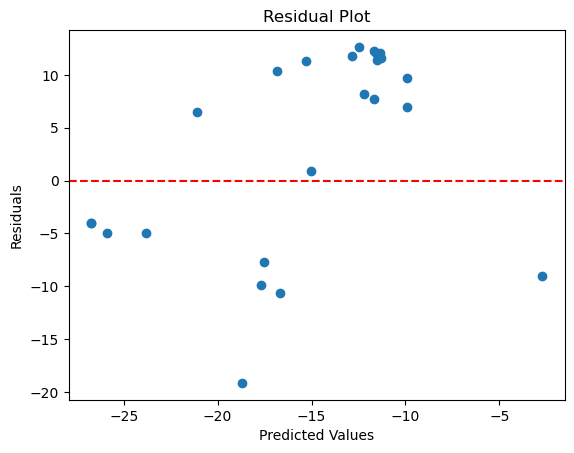

Current Timestamp:  2024-02-11 21:03:20.792869


In [33]:
# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid, gp_sparse,'gpy')

mse, r2 = evaluate_model_performance(gp_sparse, X_new_points, Y_new_points,'gpy')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()